comparison

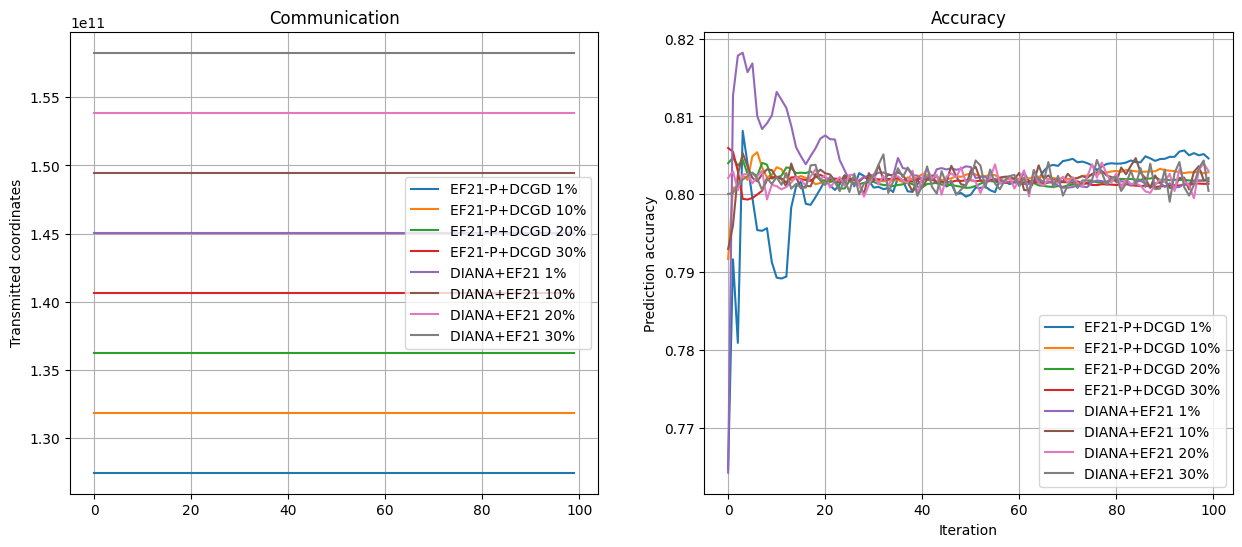

In [6]:
class EF21_DCGDPWorkerToServerCompressor(WorkerToServerCompressor):
    def __init__(self, compression_ratio, n_features):
        super().__init__(compression_ratio)
        self.memory = np.zeros(n_features)

    def compress(self, gradient_device):
        k = max(1, int(len(gradient_device) * self.compression_ratio))
        selected_indices = np.random.choice(len(gradient_device), size=k, replace=False)
        compressed = gradient_device[selected_indices]

        # Update memory
        self.memory[selected_indices] = gradient_device[selected_indices] - compressed

        self.transmitted_coordinates += len(compressed)
        return compressed, selected_indices

    def decompress(self, compressed_gradient, selected_indices, original_size):
        decompressed = super().decompress(compressed_gradient, selected_indices, original_size)
        return decompressed + self.memory


class DIANA_EF21AWorkerToServerCompressor(WorkerToServerCompressor):
    def __init__(self, compression_ratio, n_features):
        super().__init__(compression_ratio)
        self.memory = np.zeros(n_features)

    def compress(self, gradient_device):
        gradient_diff = gradient_device - self.memory

        k = max(1, int(len(gradient_diff) * self.compression_ratio))
        selected_indices = np.random.choice(len(gradient_diff), size=k, replace=False)
        compressed = gradient_diff[selected_indices]

        # Update memory
        self.memory[selected_indices] += compressed

        self.transmitted_coordinates += len(compressed)
        return compressed, selected_indices

    def decompress(self, compressed_gradient, selected_indices, original_size):
        decompressed = super().decompress(compressed_gradient, selected_indices, original_size)
        return decompressed


#
n_features = X_train.shape[1]

compression_methods = {
    "EF21-P+DCGD": EF21_DCGDPWorkerToServerCompressor,
    "DIANA+EF21": DIANA_EF21AWorkerToServerCompressor,
}

plt.figure(figsize=(15, 6))

for method_name, compressor_class in compression_methods.items():
    for ratio in compression_ratios:
        worker_to_server_compressor = compressor_class(ratio, n_features)

        simulator = DistributedEnvSimulator(
            nabla_f=nabla_f,
            gamma_k=gamma_k,
            worker_to_server_compressor=worker_to_server_compressor,
        )

        (
            weights,
            convergence,
            accuracies,
            execution_time,
            transmitted_coordinates_worker_to_server,
            transmitted_coordinates_server_to_worker,
        ) = simulator.simulate_distributed_env(
            X=X_train,
            y=y_train,
            n_devices=n_devices,
            num_iterations=num_iterations,
        )

        plt.subplot(1, 2, 1)
        plt.plot(
            np.full(
                len(accuracies),
                transmitted_coordinates_server_to_worker + transmitted_coordinates_worker_to_server,
            ),
            label=f"{method_name} {int(ratio * 100)}%",
        )

        plt.subplot(1, 2, 2)
        plt.plot(np.array(accuracies), label=f"{method_name} {int(ratio * 100)}%")

plt.subplot(1, 2, 1)
plt.ylabel("Transmitted coordinates")
plt.grid(True)
plt.legend()
plt.title("Communication")

plt.subplot(1, 2, 2)
plt.xlabel("Iteration")
plt.ylabel("Prediction accuracy")
plt.grid(True)
plt.legend()
plt.title("Accuracy")

plt.show()
